# Gradient-based Algorithms and Differentiable Programming
# Inverted Pendulum

MAE 598 Design Optimization

In [ ]:
# Importing required Libraries

import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)

In [ ]:
# defining constants
Frame_Time = 0.1
M_Cart = 6
M_Pendulum = 2
L = 1
g = 9.81

In [ ]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):

        """
        state[0] = x
        state[1] = x_dot
        state[2] = thetha
        state[3] = thetha_dot

        action[0] = force, u

        d_state[0] = x_dot
        d_state[1] = x_ddot
        d_state[2] = thetha_dot
        d_state[3] = thetha_ddot

        x_ddot = (a * state[0,2]) + (b * state[0,3]) + (c * action)

        thetha_ddot = (d * state[0,2]) - (e * state[0,3]) - (f * action)

        state = state + d_state * delta_time

        """

        # calculating x double dot
        a_num = - M_Pendulum * g * torch.cos(state[0,2]) * torch.sin(state[0,2])
        a_deno = (M_Cart + (M_Pendulum * torch.square(torch.sin(state[0,2]))))*state[0,2]
        a = a_num/a_deno

        b_num = M_Pendulum * L * torch.sin(state[0,2]) * state[0,3]
        b_deno = M_Cart + (M_Pendulum * torch.square(torch.sin(state[0,2])))
        b = b_num/b_deno

        c_num = 1
        c_deno = M_Cart + (M_Pendulum * torch.square(torch.sin(state[0,2])))
        c = c_num/c_deno

        x_ddot = (a * state[0,2]) + (b * state[0,3]) + (c * action)

        # calculating thetha double dot
        d_num = (M_Cart + M_Pendulum) * g * torch.sin(state[0,2])
        d_deno = (M_Cart + (M_Pendulum * torch.square(torch.sin(state[0,2])))) * L * state[0,2]
        d = d_num/d_deno

        e_num = M_Pendulum * torch.sin(state[0,2]) * torch.cos(state[0,2]) * state[0,3]
        e_deno = M_Cart + (M_Pendulum * torch.square(torch.sin(state[0,2])))
        e = e_num / e_deno

        f_num = torch.cos(state[0,2])
        f_deno = (M_Cart + (M_Pendulum * torch.square(torch.sin(state[0,2])))) * L
        f = f_num / f_deno

        thetha_ddot = (d * state[0,2]) - (e * state[0,3]) - (f * action)

        d_state = torch.zeros((1, 4))
        d_state[0,0] = state[0,1]
        d_state[0,1] = x_ddot
        d_state[0,2] = state[0,3]
        d_state[0,3] = thetha_ddot

        # print(d_state)

        state = state + (d_state * Frame_Time)

        return state

In [ ]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden:
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        # Scale the output to the range [0, 1]
        action = torch.sigmoid(action)
        # Scale and shift to the range [0, 100]
        action = action * 100.0
        return action


In [ ]:
class Simulation(nn.Module):
    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(self.T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # Initial state: [x, x_dot, theta, theta_dot]
        # theta = np.pi for vertically downward position
        state = [[0., 0., np.pi, 0.]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        # Normalize theta to the range [-pi, pi]
        normalized_theta = (state[0,2] + np.pi) % (2 * np.pi) - np.pi
        # Calculate error as the square of the deviation from the upright position
        return torch.mean((normalized_theta ** 2))


In [ ]:
class Optimize:

    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects

    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient


            # for name, param in self.simulation.controller.named_parameters():
            #     if param.requires_grad:
            #         print(name, param.grad)

            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model


    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()

        plt.plot(list(range(epochs)), l)

        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)

    def visualize(self):
      data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
      x = data[:, 0]  # Position of the cart
      x_dot = data[:, 1]  # Velocity of the cart
      theta = data[:, 2]  # Angle of the pendulum (from vertical)
      theta_dot = data[:, 3]  # Angular velocity of the pendulum

      action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
      force = action_data[:, 0]  # Force applied to the cart
      frame = range(self.simulation.T)

      fig, ax = plt.subplots(1, 5, tight_layout=True, figsize=(20, 5))  # Increased to 5 subplots

    # Cart Position Plot
      ax[0].plot(frame, x, c='b')
      ax[0].set_xlabel("Time")
      ax[0].set_ylabel("Position (x)")
      ax[0].set_title(f'Displacement of Cart (x) at Frame {self.epoch}')

    # Cart Velocity Plot
      ax[1].plot(frame, x_dot, c='c', label="Velocity of Cart (x_dot)")
      ax[1].set_xlabel("Time")
      ax[1].set_ylabel("Velocity (m/s)")
      ax[1].legend(frameon=False)
      ax[1].set_title(f'Velocity of Cart at Frame {self.epoch}')

    # Pendulum Angle Plot
      ax[2].plot(frame, theta, c='g', label="Pendulum Angle (Theta)")
      ax[2].set_xlabel("Time")
      ax[2].set_ylabel("Angle (radians)")
      ax[2].legend(frameon=False)
      ax[2].set_title(f'Pendulum Angle at Frame {self.epoch}')

    # Pendulum Angular Velocity Plot
      ax[3].plot(frame, theta_dot, c='m', label="Pendulum Angular Velocity (Theta_dot)")
      ax[3].set_xlabel("Time")
      ax[3].set_ylabel("Angular Velocity (rad/s)")
      ax[3].legend(frameon=False)
      ax[3].set_title(f'Pendulum Angular Velocity at Frame {self.epoch}')

    # Force Applied to Cart Plot
      ax[4].plot(frame, force, c='y', label="Force on Cart")
      ax[4].set_xlabel("Time")
      ax[4].set_ylabel("Force (N)")
      ax[4].legend(frameon=False)
      ax[4].set_title(f'Force on Cart at Frame {self.epoch}')

      plt.show()

    def animation(self, epochs):
    # Increased size specifications for cart and pendulum
      length_cart = 0.5  # Increased length of the cart
      width_cart = 0.75   # Increased width of the cart
      length_pendulum = 2.0  # Increased length of the pendulum

      print("Generating Animation")
      steps = self.simulation.T + 1
      final_time_step = round(1/steps, 2)

    # Extracting state and action data
      data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
      x_t = data

    # Set up the figure
      fig = plt.figure(figsize=(12, 8))
      ax1 = fig.add_subplot(111)

    # Initialize plot elements
      ln1, = ax1.plot([], [], 's', markersize=30, color='blue')  # Increased cart size
      ln2, = ax1.plot([], [], 'o-', linewidth=3, color='red')   # Increased pendulum size

    # Adjusted axis limits
      ax1.set_xlim(-10, 10)
      ax1.set_ylim(-2, 3)
      ax1.set_aspect('equal')

    # Update function for animation
      def update(i):
        cart_x = x_t[i, 0]
        cart_y = width_cart / 2

        pendulum_x = cart_x + length_pendulum * np.sin(x_t[i, 2])
        pendulum_y = cart_y + length_pendulum * np.cos(x_t[i, 2])

        ln1.set_data(cart_x, cart_y)  # Update cart position
        ln2.set_data([cart_x, pendulum_x], [cart_y, pendulum_y])  # Update pendulum position

    # Slower animation settings
      interval_ms = 200  # Increase for slower animation
      fps = 5  # Decrease fps for slower animation

      anim = FuncAnimation(fig, update, frames=steps-1, interval=interval_ms)

    # Save as GIF
      gif_path = "/content/inverted_pendulum_animation_v9.gif"
      writer = PillowWriter(fps=fps)
      anim.save(gif_path, writer=writer)
      print(f"Animation saved as {gif_path}")

    # Close the figure
      plt.close(fig)


[1] loss: 1.346


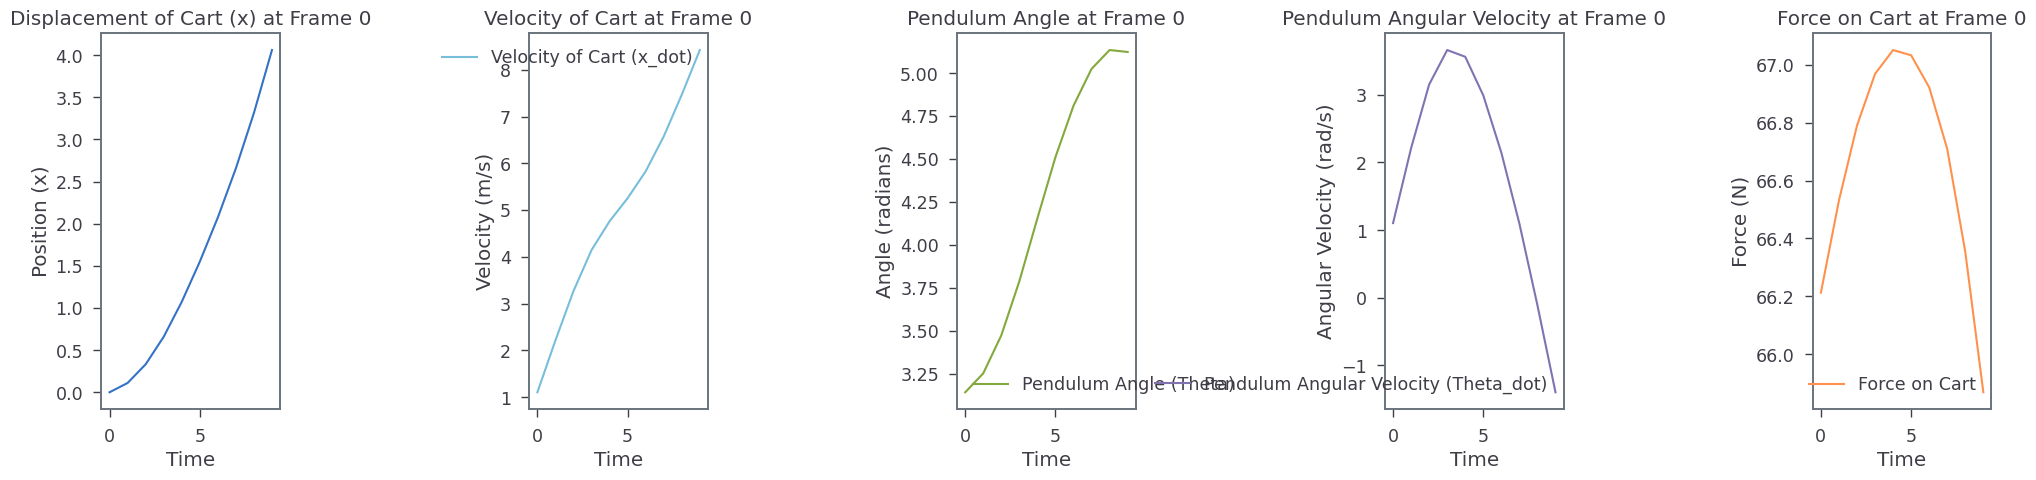

[2] loss: 1.210


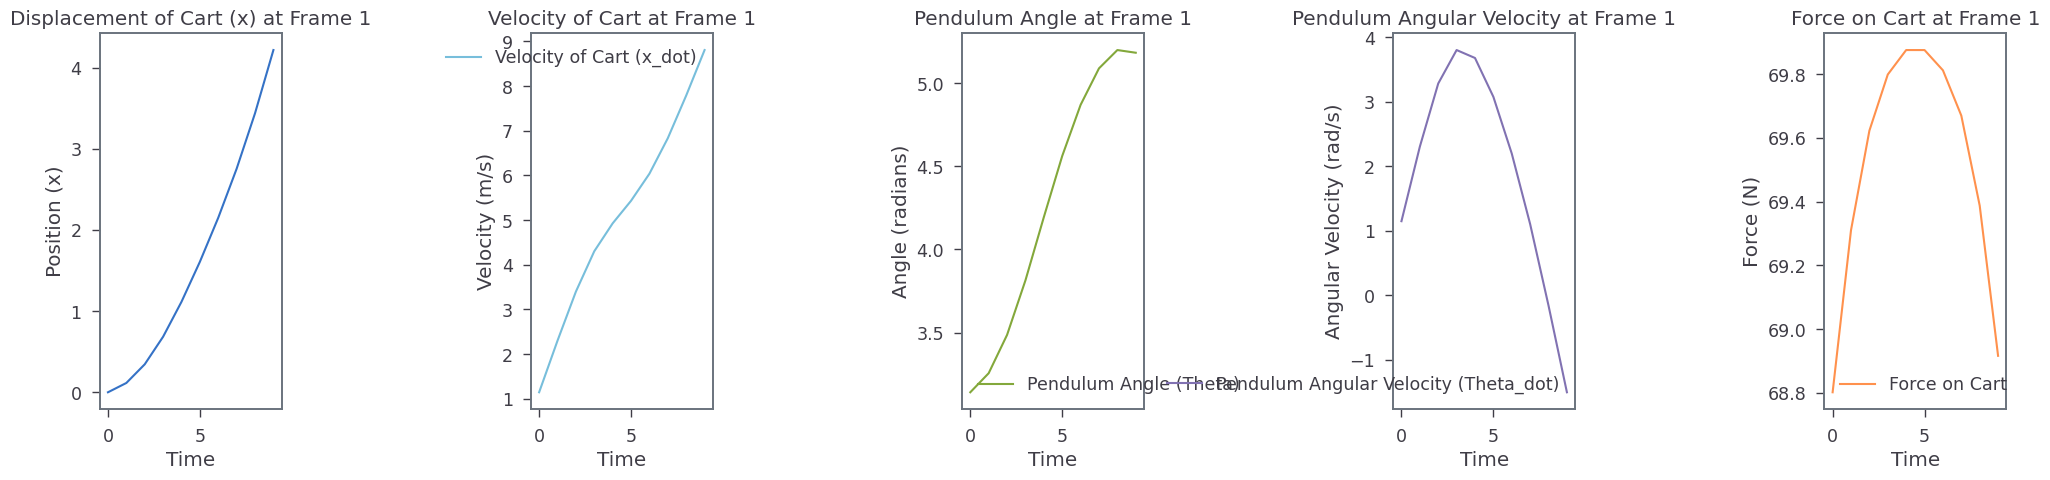

[3] loss: 1.150


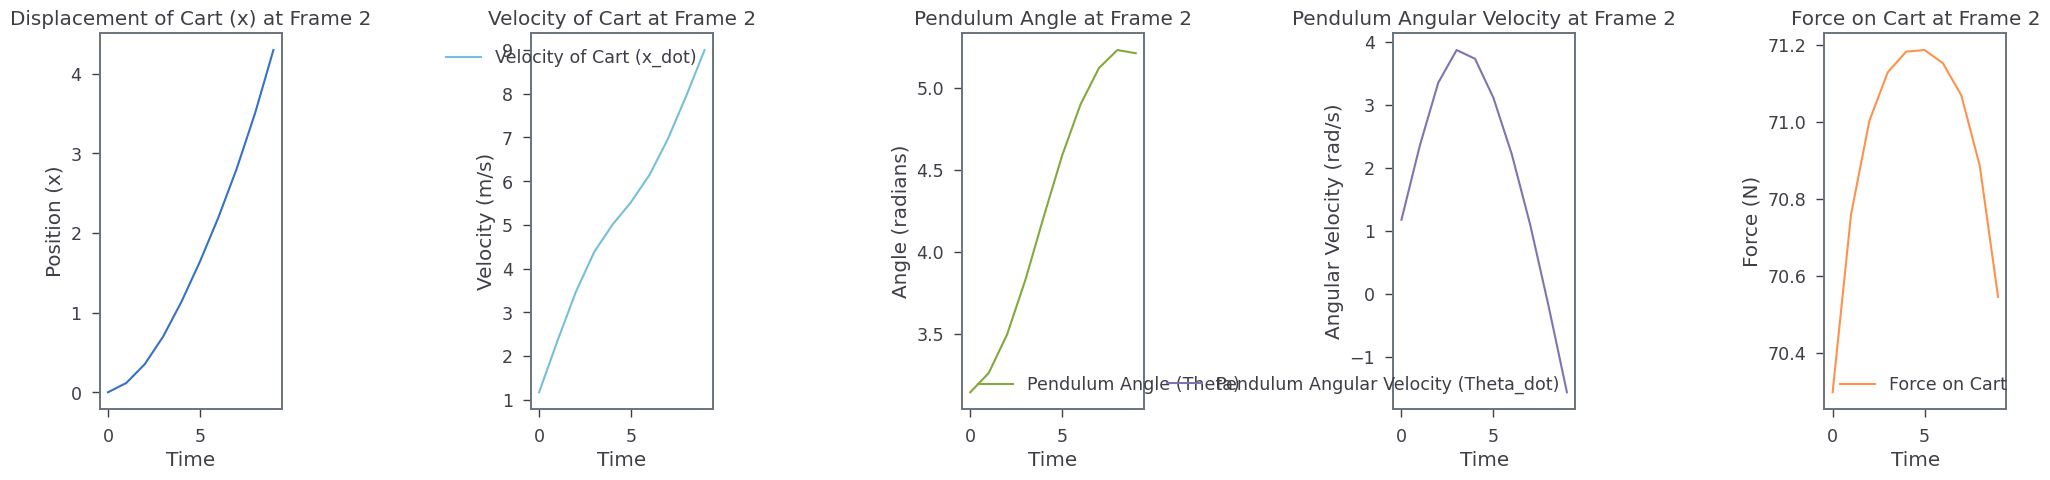

[4] loss: 1.117


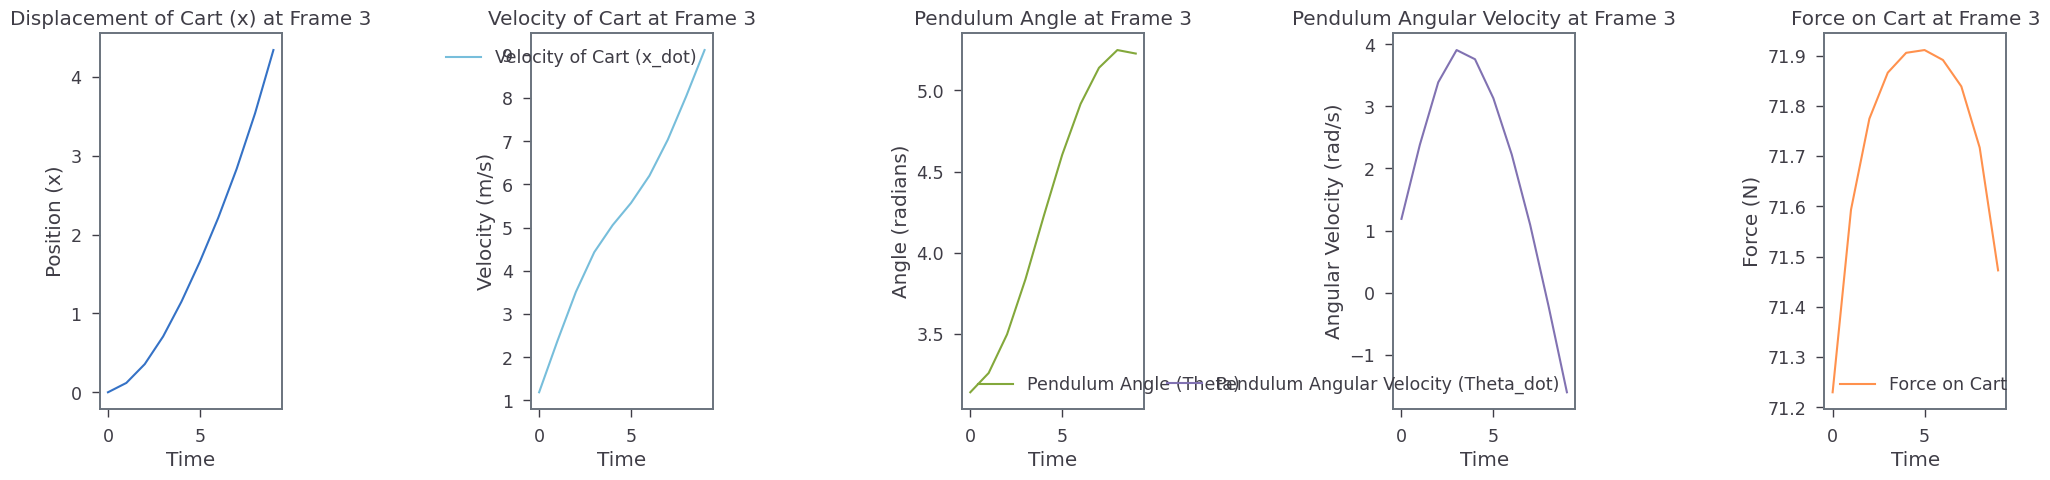

[5] loss: 1.100


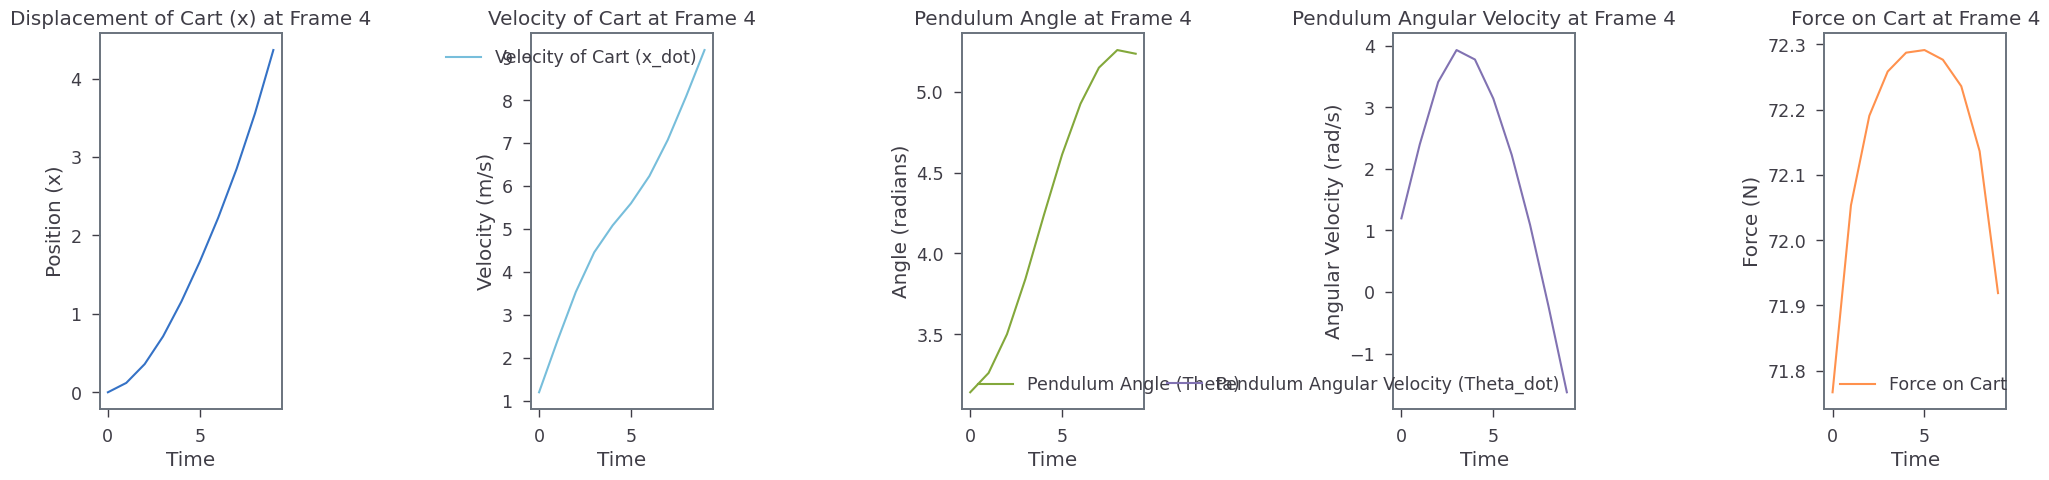

[6] loss: 1.090


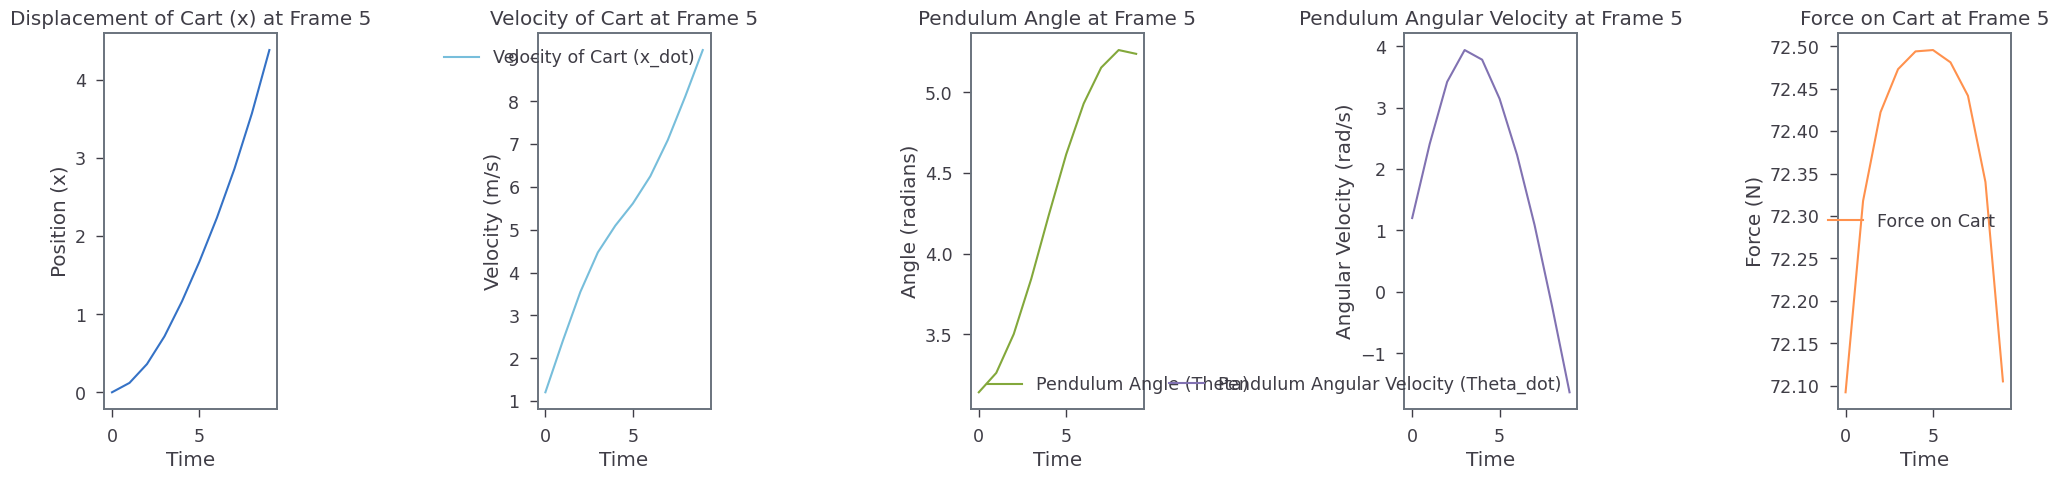

[7] loss: 1.081


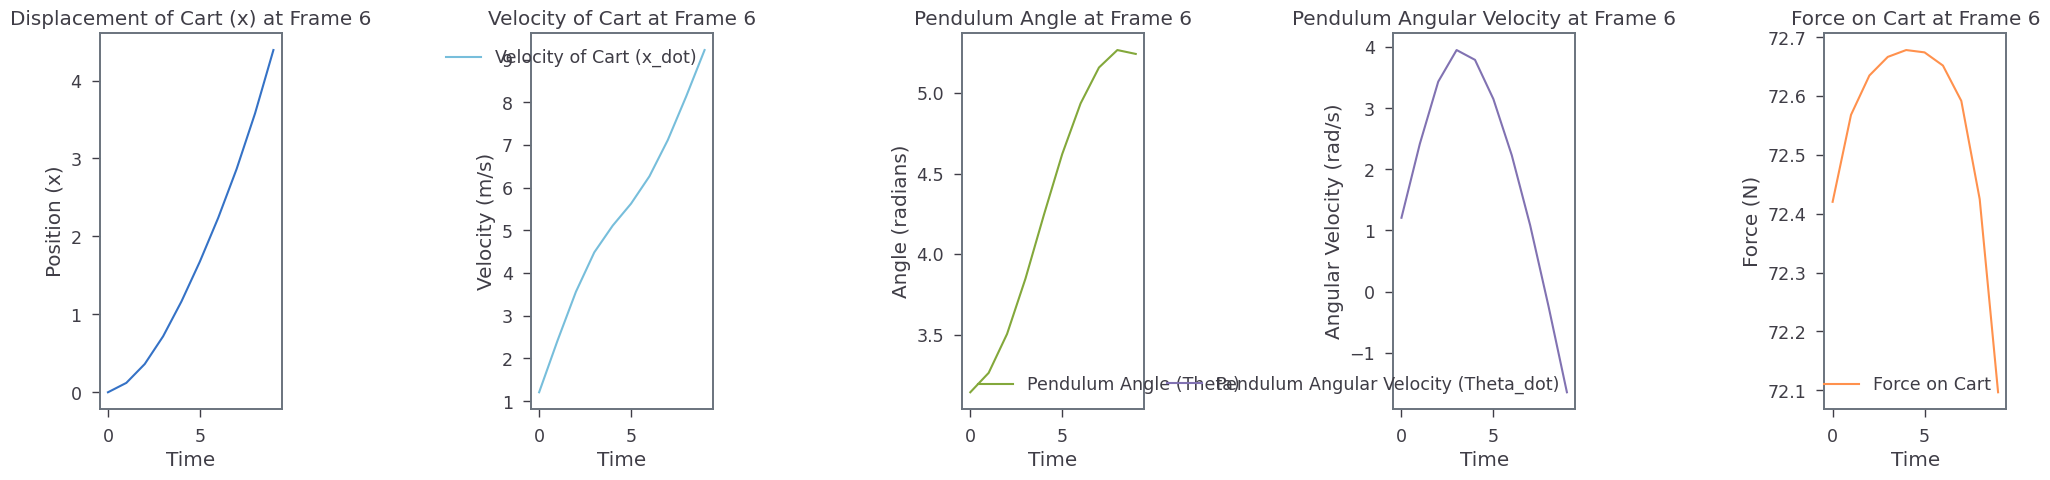

[8] loss: 1.073


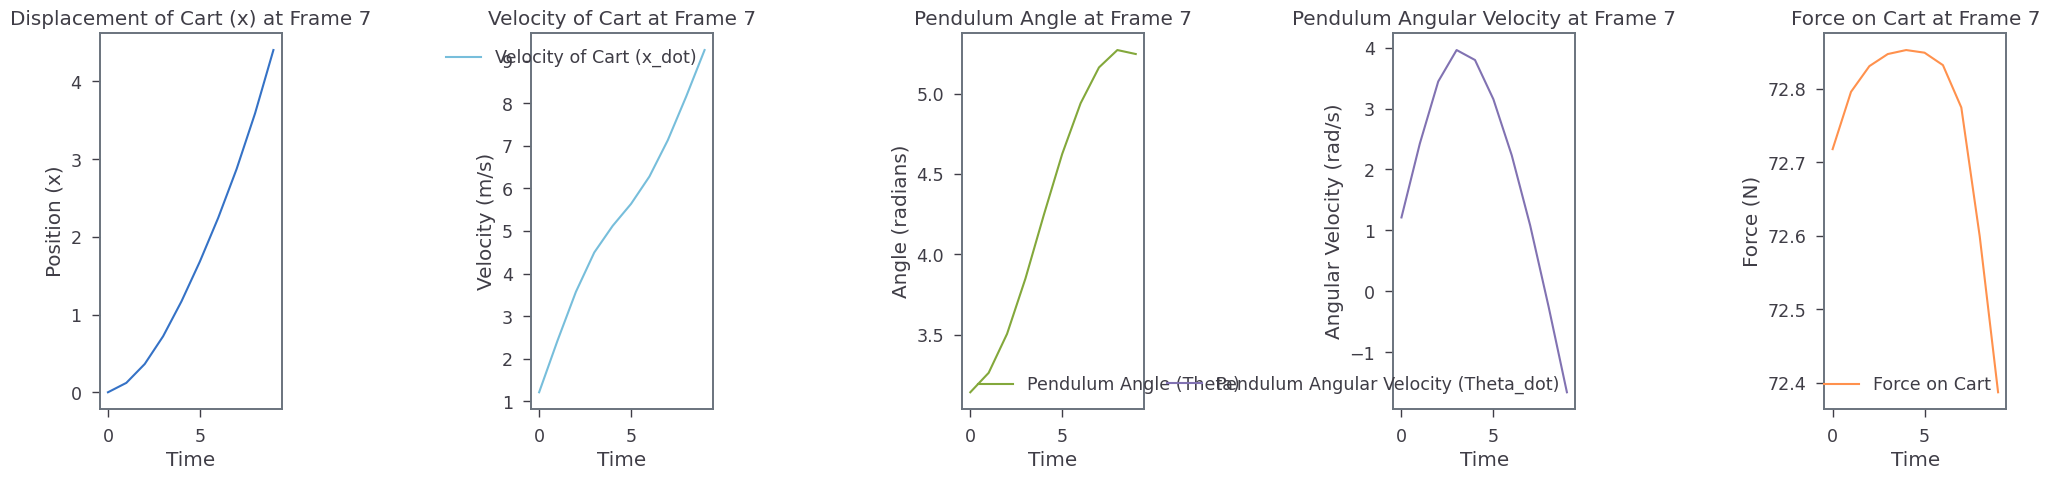

[9] loss: 1.070


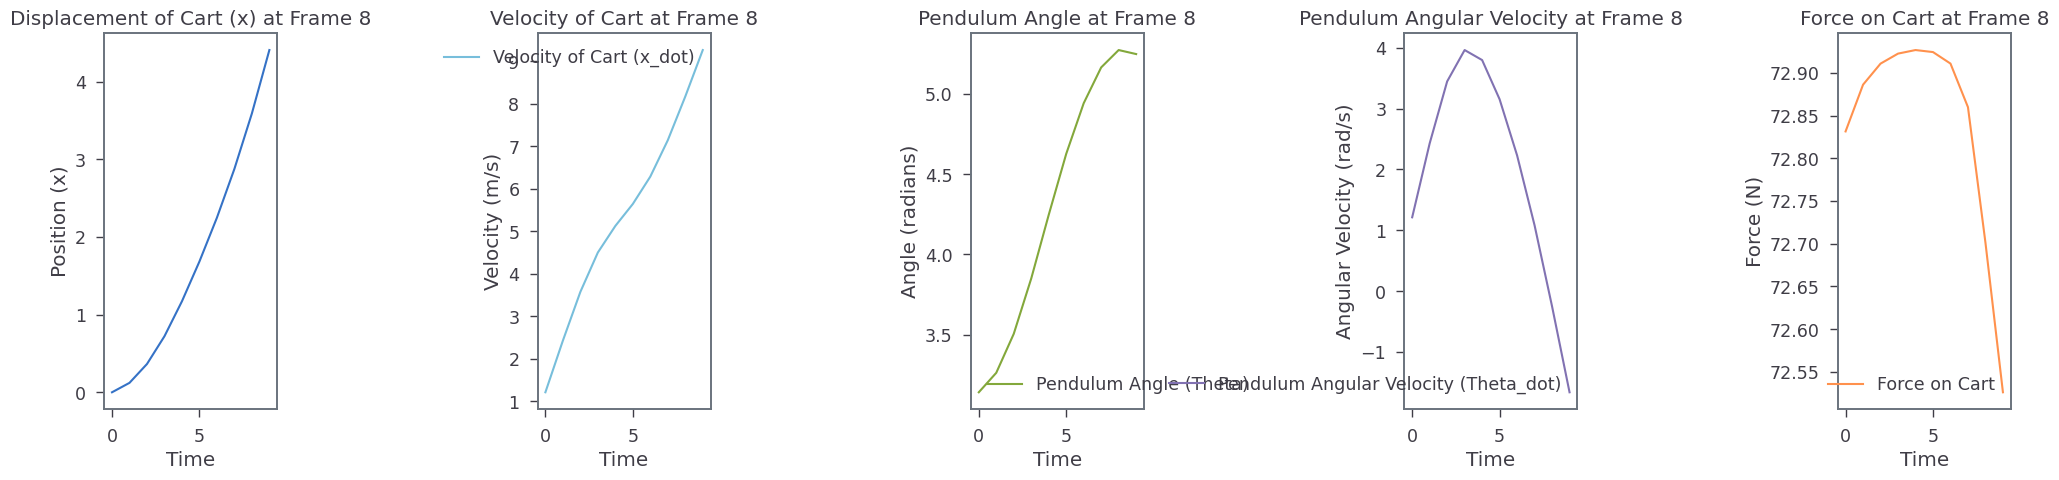

[10] loss: 1.045


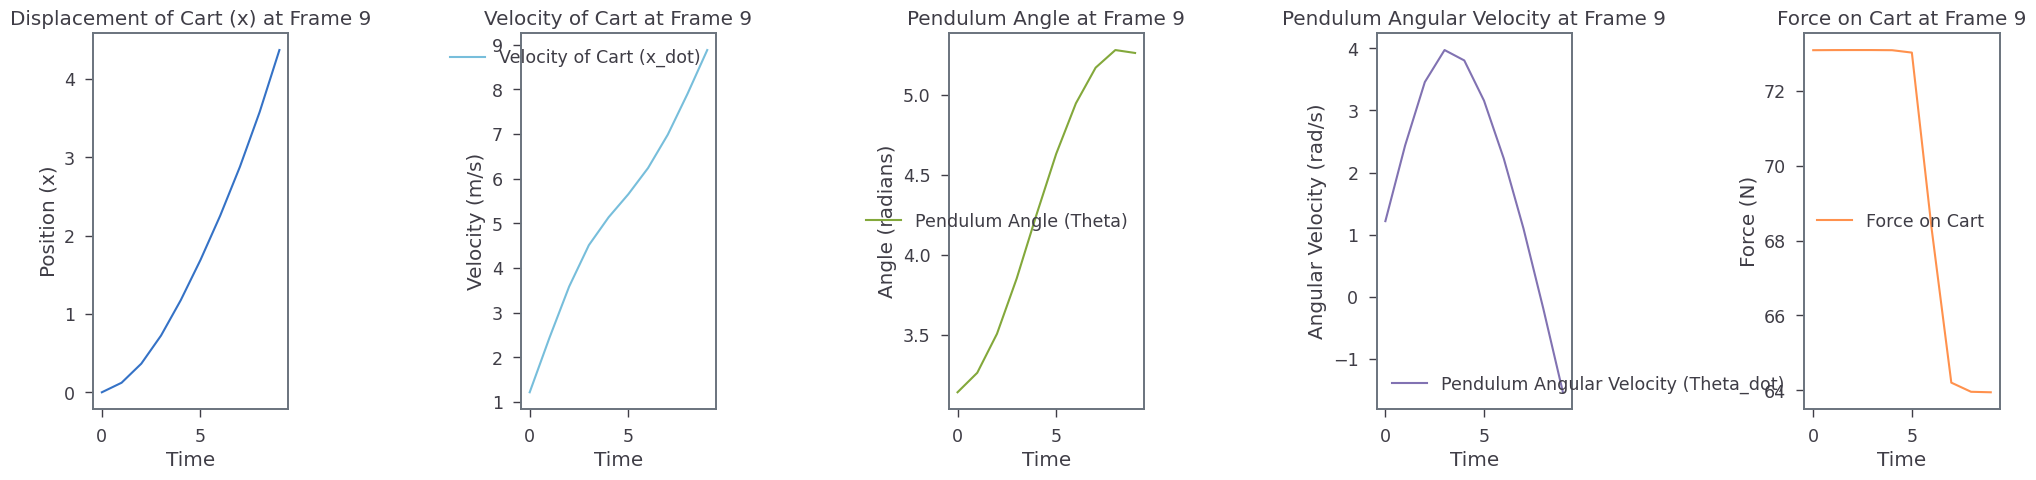

[11] loss: 1.020


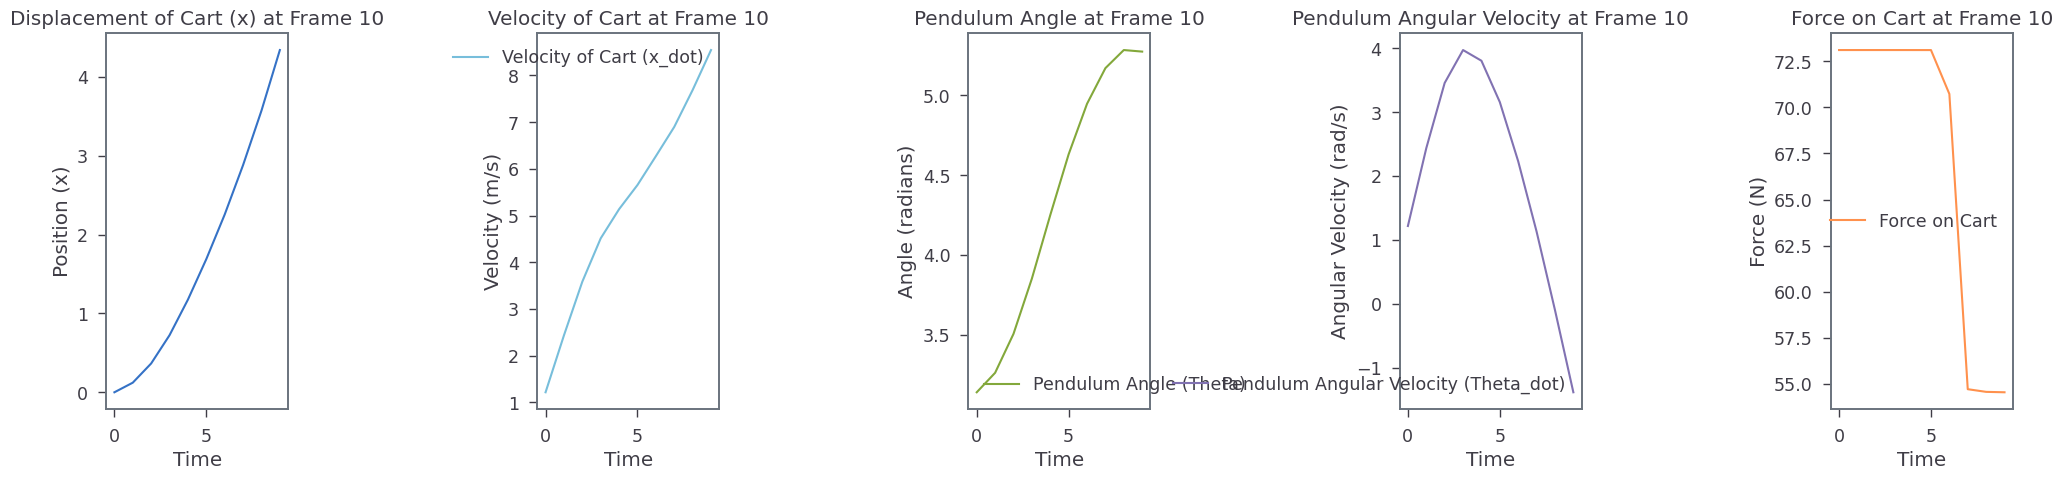

[12] loss: 1.013


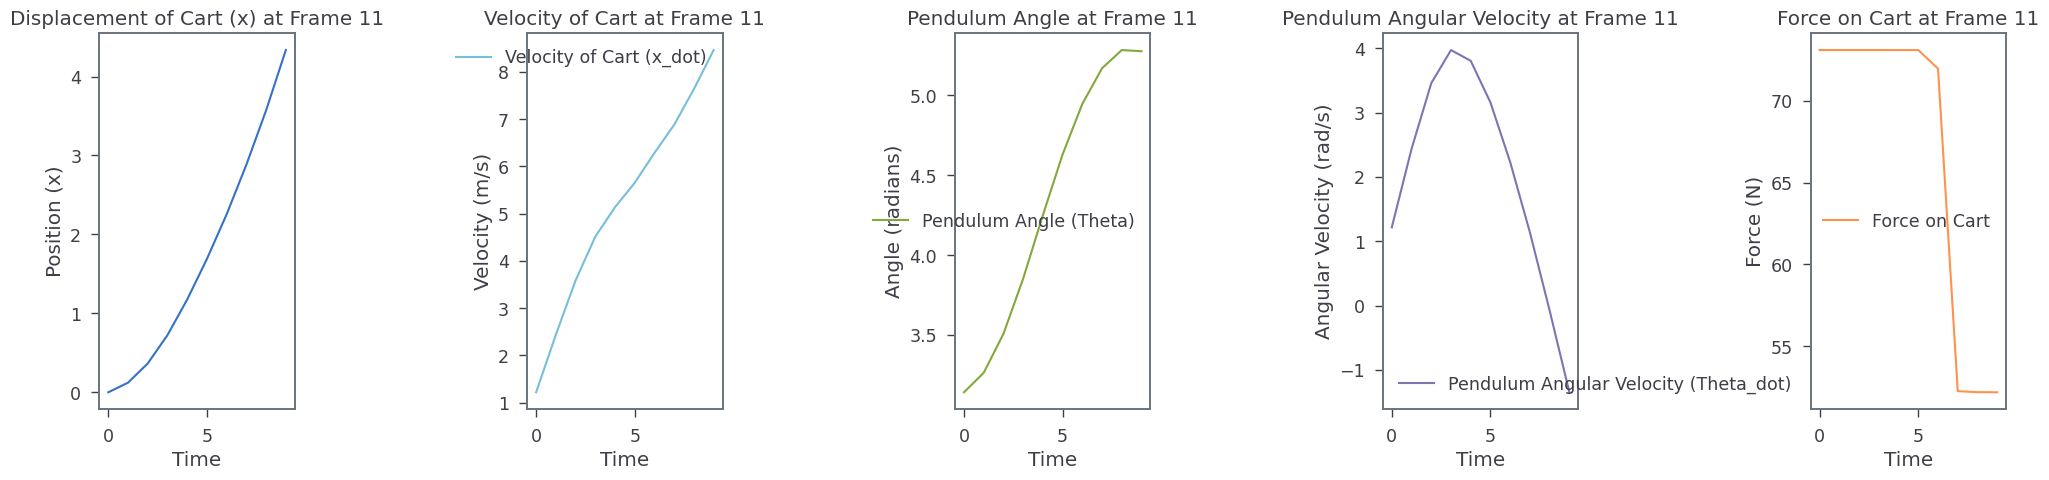

[13] loss: 1.010


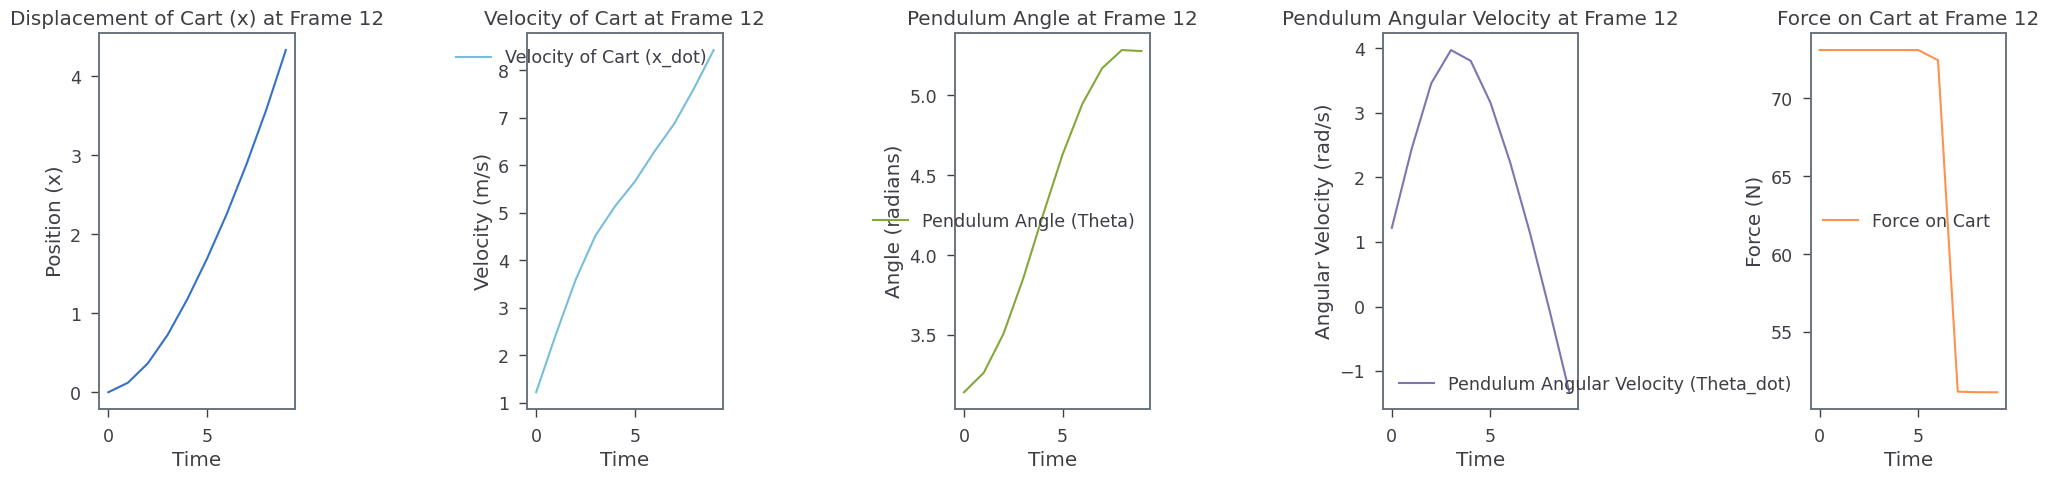

[14] loss: 1.009


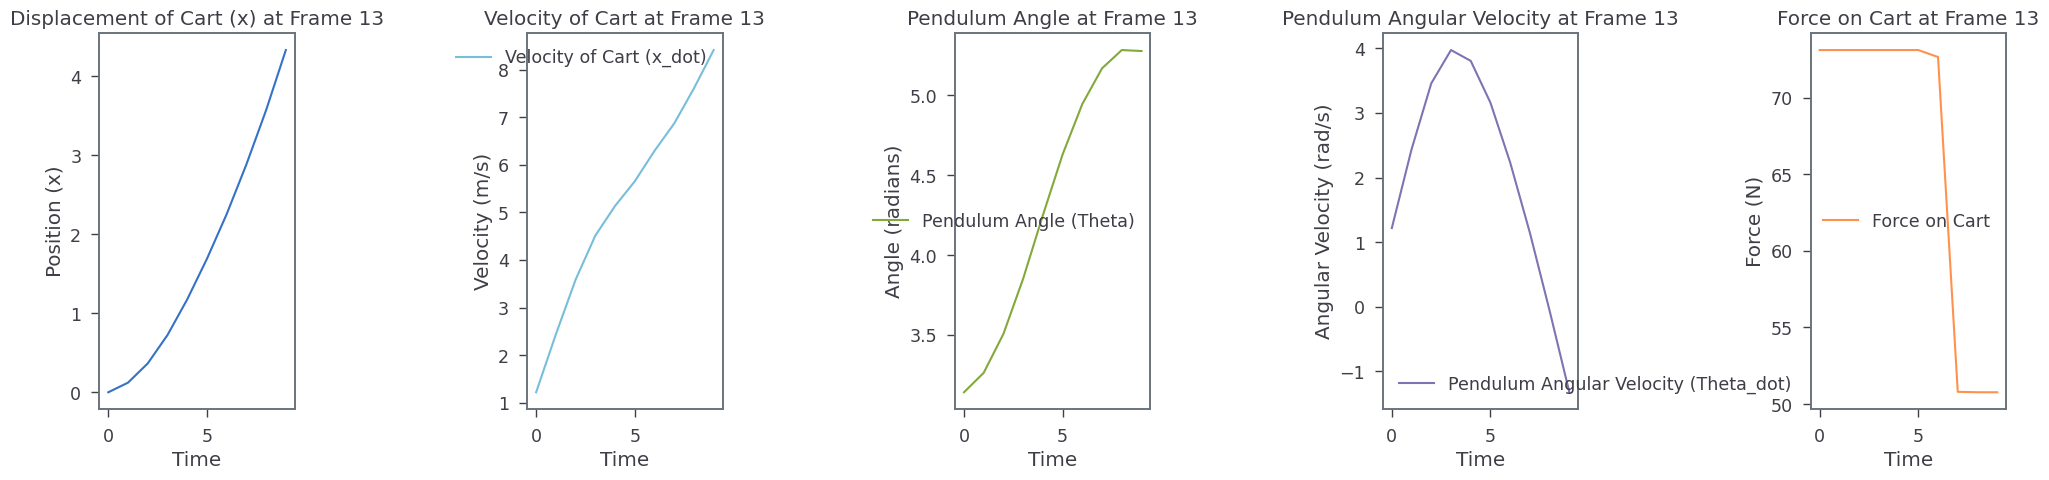

[15] loss: 1.009


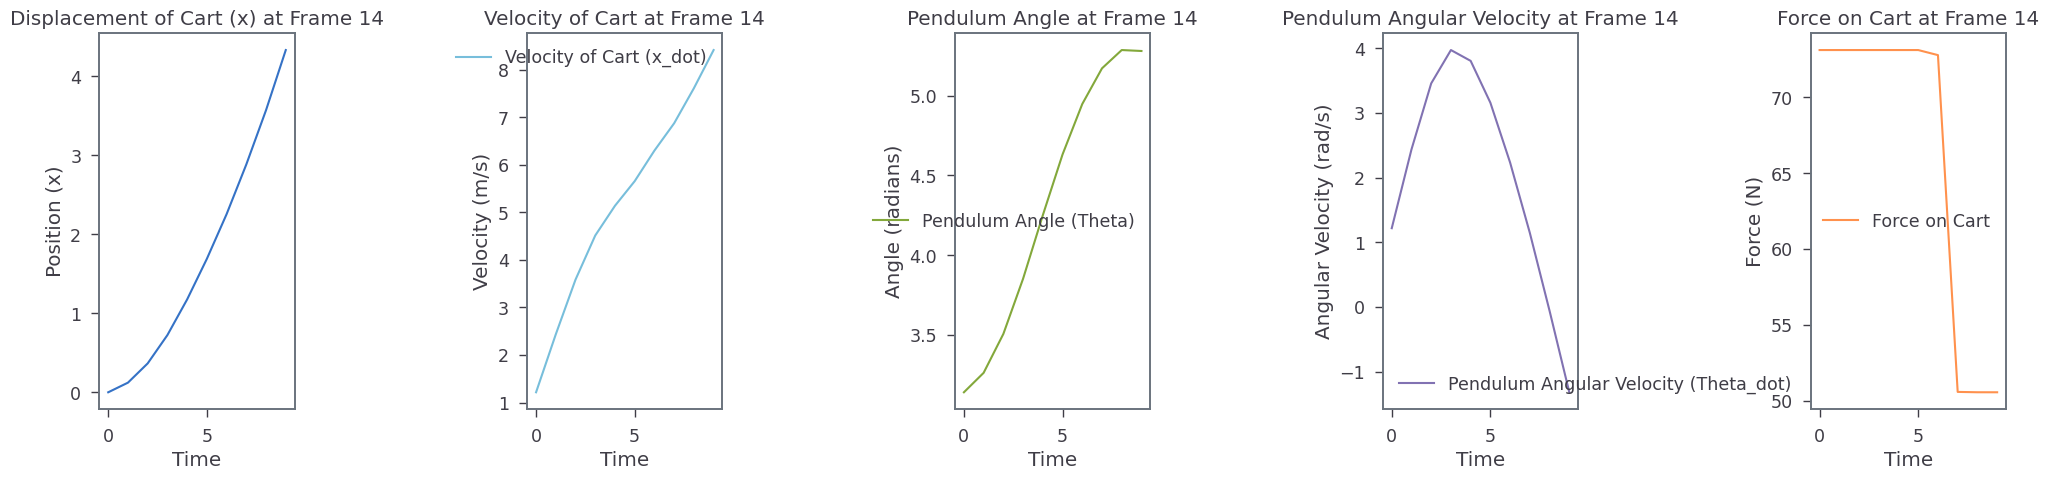

[16] loss: 1.009


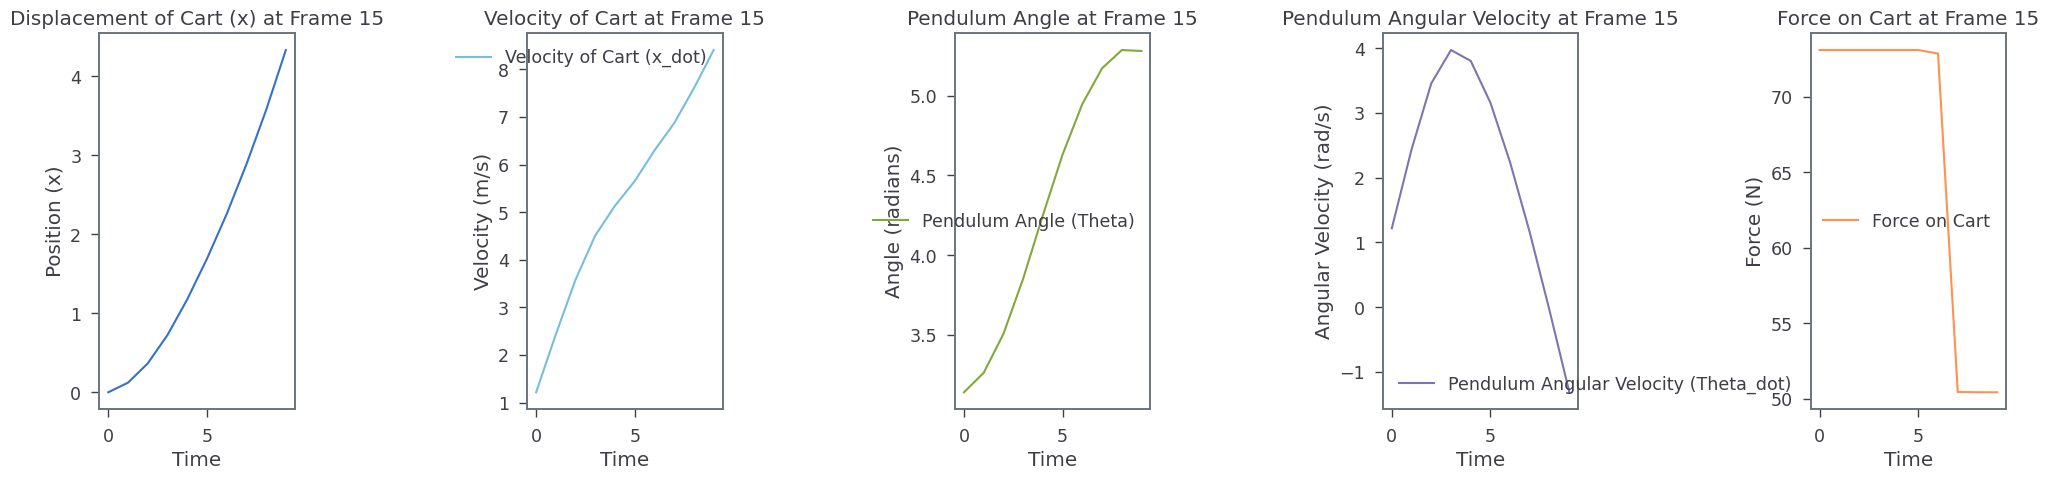

[17] loss: 1.008


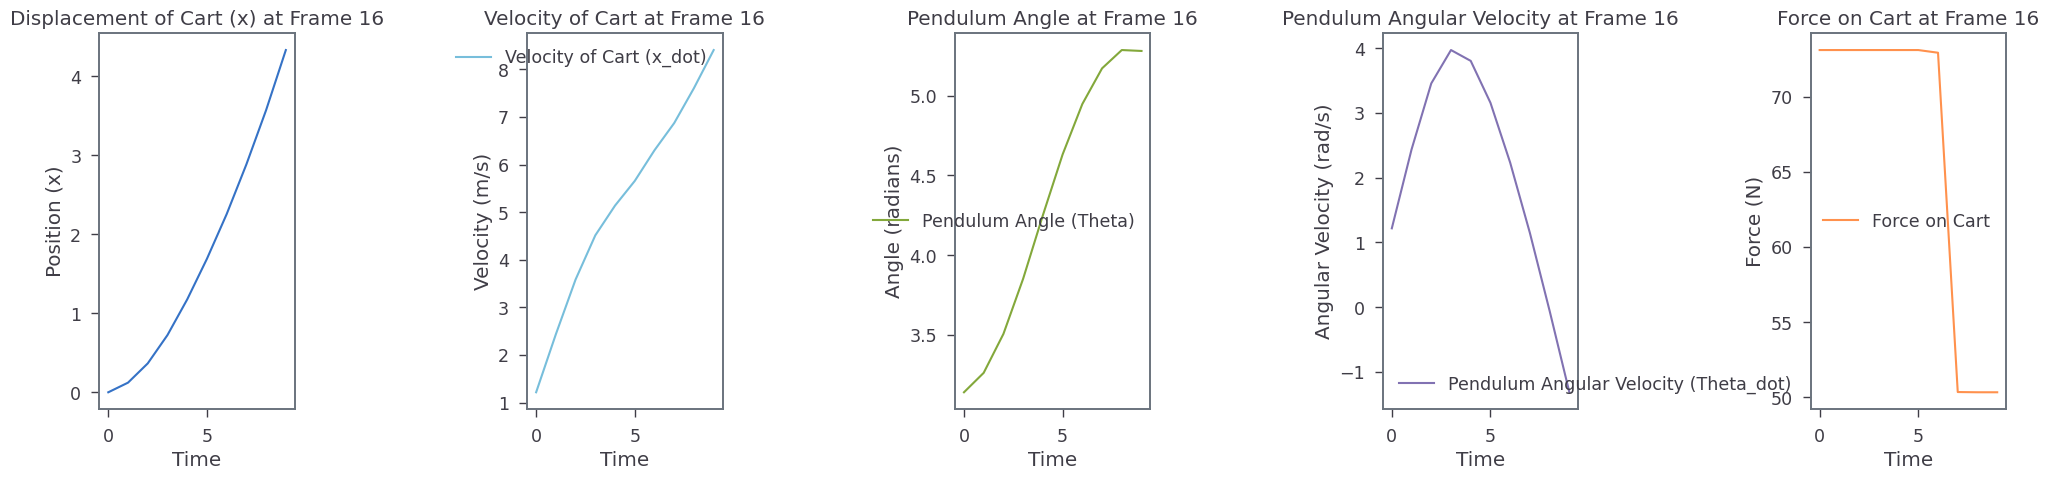

[18] loss: 1.008


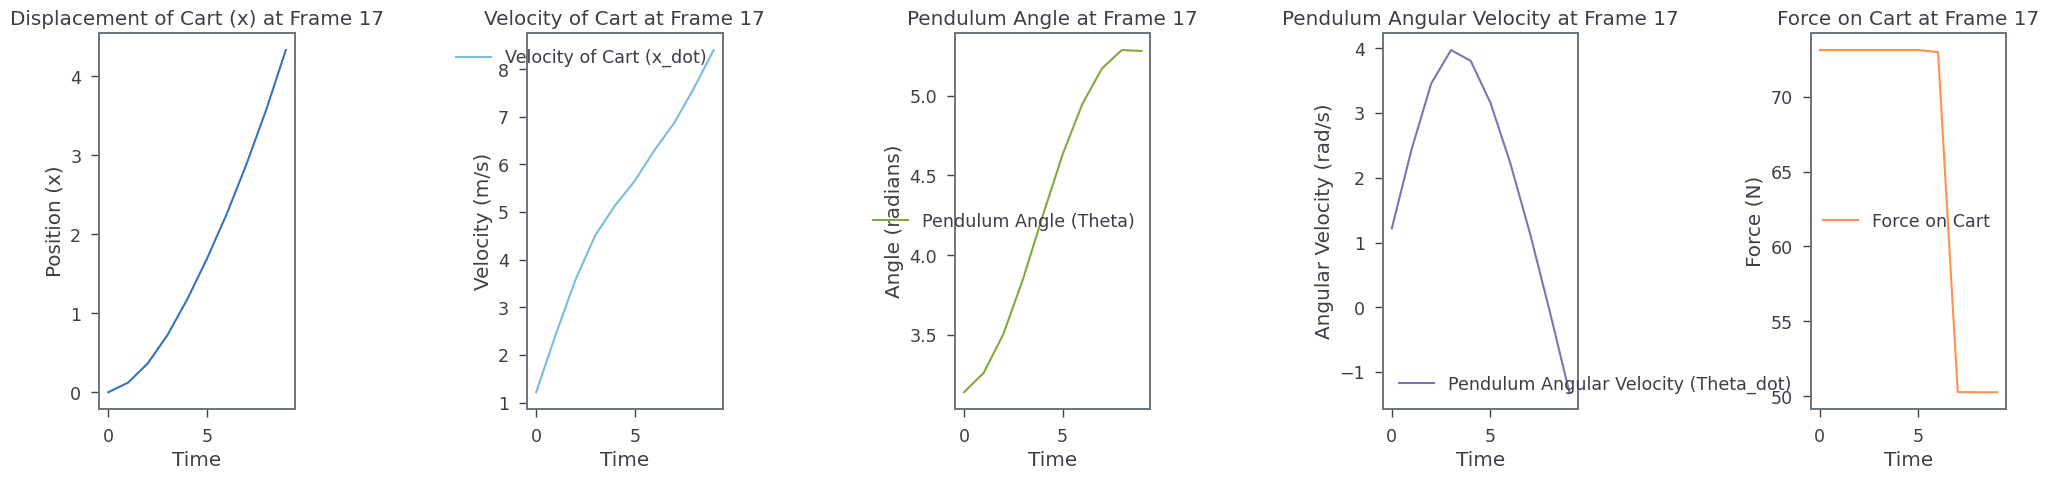

[19] loss: 1.008


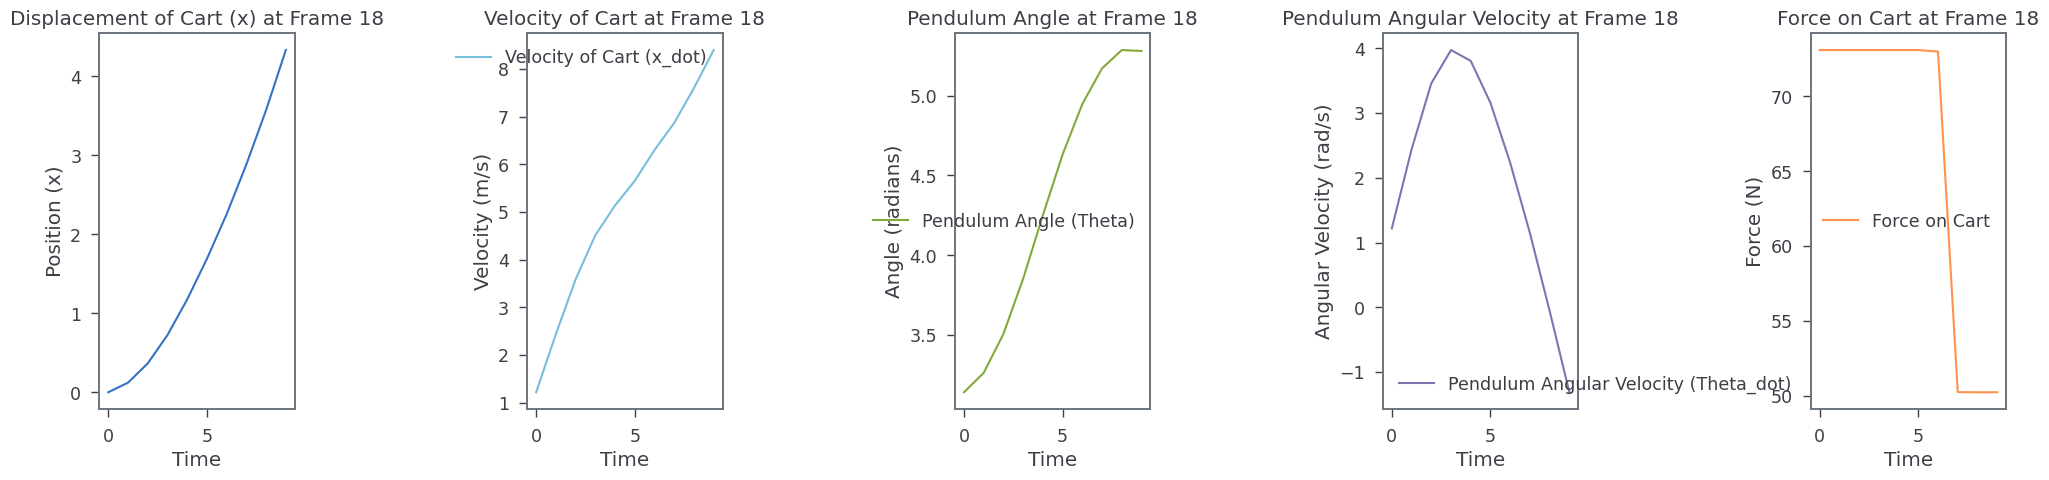

[20] loss: 1.008


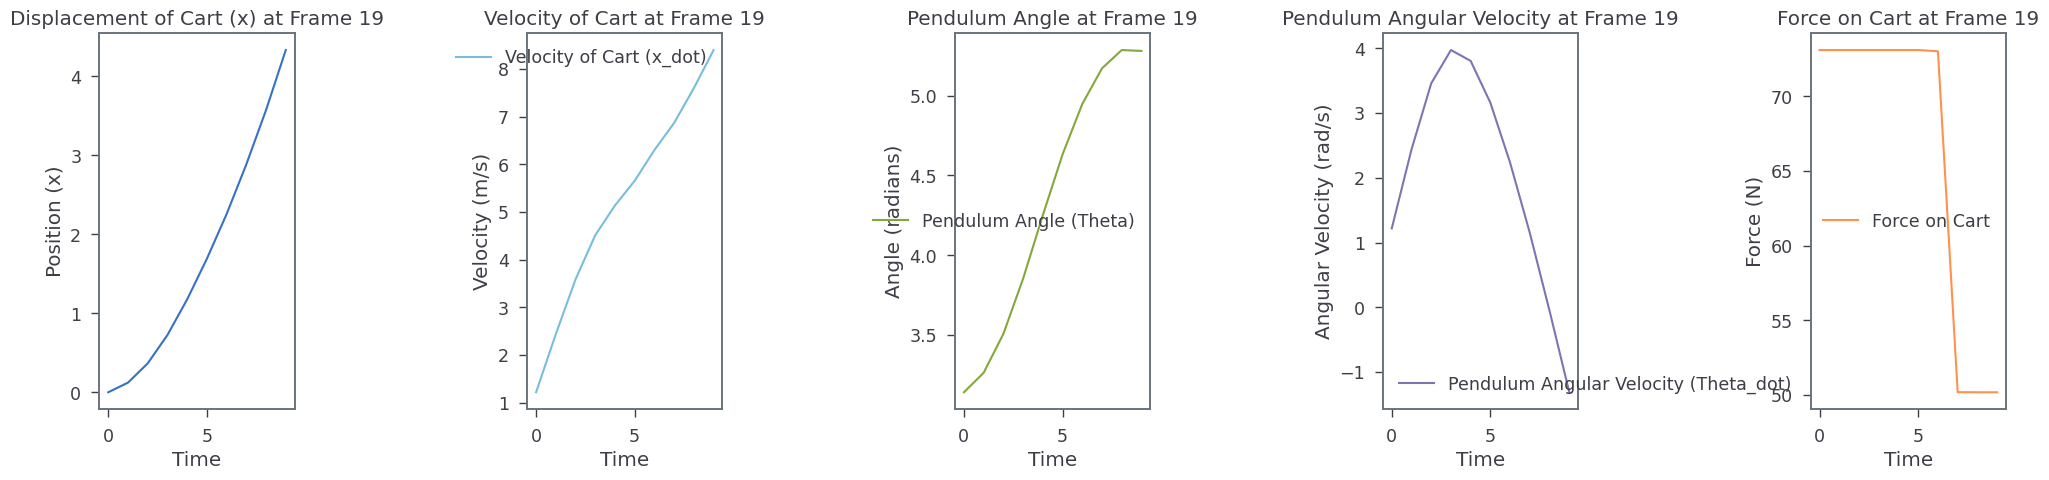

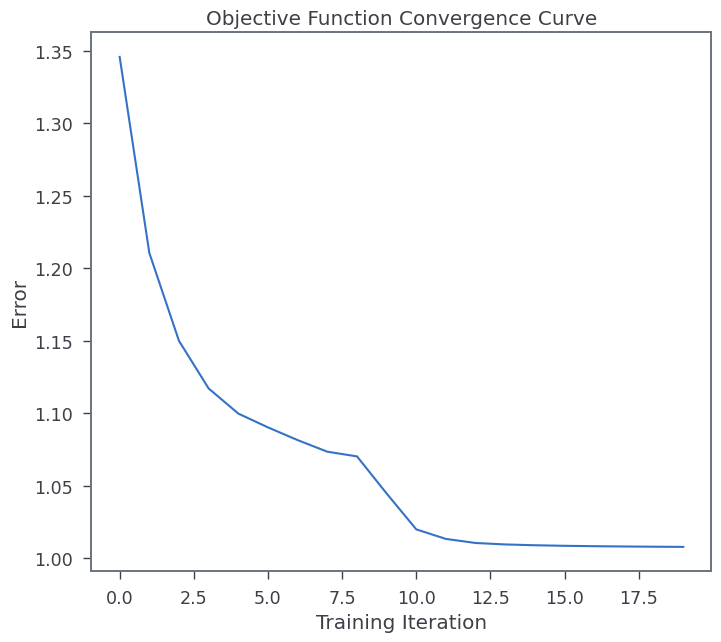

Generating Animation


<ipython-input-44-405fdc1a698e>:136: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ln1.set_data(cart_x, cart_y)  # Update cart position


Animation saved as /content/inverted_pendulum_animation_v9.gif


In [ ]:
T = 10 # number of time steps of the simulation
dim_input = 4  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()
c = Controller(dim_input, dim_hidden, dim_output)
s = Simulation(c, d, T)
o = Optimize(s)
o.train(20)  # training with number of epochs (gradient descent steps)

# Analysis of Result

**Issues resolved**

•	PyTorch implementation of Dynamical equation posed a challenge, arising issues from indentation error to gradient explosion due to small mistake in encoding dynamics.

•	Hyperparameters selection for both algorithms LBFGS and neural was a task requiring trial and error to strike a good balance.

•	Loss function stagnation was experience due to inappropriate initial condition, gradient explosion and bugs in code.

**Lessons learnt**

•	The project significantly enhanced our understanding of dynamics and convex optimization, providing a practical and hands-on experience in addressing real-world challenges.

•	Proficiency in the PyTorch framework was achieved, giving us valuable skills in implementing optimization algorithm for complex problems.

•	The project served as a platform for gaining expertise in optimization problem formulation, a crucial step in the field of convex optimization.

•	Debugging skills in Python were greatly improved, as we navigated through challenges in the codebase to ensure the proper functioning of the algorithms.

